In [1]:
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import random
from matplotlib import colors
import copy
import time
import scipy.optimize
import datetime

%matplotlib inline

In [2]:
def plot_ising_grid(init, title):
    """Creates a discrete colormap for an input Ising grid, red for up (1) and blue for down (-1)"""
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    cmap = colors.ListedColormap(['blue', 'red'])
    bounds = [0,1,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(init, cmap=cmap, norm=norm)
    plt.title(title, fontsize=20)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    display.clear_output(wait = True)

    plt.show()

In [3]:
# assumes periodic BCs
def metropolis_ising_af(init, boltz):
    """Returns a mesh evolved by one step of applying the Metropolis algorithm, the energy change, 
    and the magnetization change"""
    
    mesh = copy.copy(init)
    
    X = np.shape(mesh)[1]
    Y = np.shape(mesh)[0]
    
    # select random spin from the input spin mesh
    x = random.choice(range(X))
    y = random.choice(range(Y))
    
    # applying the metropolis algorithm
    spin_sum = mesh[(y+1) % Y,x ] + mesh[y ,(x+1) % X] + mesh[(y-1) % Y,x ] + mesh[y ,(x-1) % X]
    d_energy = -2*mesh[y,x] * spin_sum
    
    if d_energy <= 0:
        mesh[y,x] = -1*mesh[y,x]
        d_mag = 2*mesh[y,x]
        
    elif random.uniform(0,1) < boltz[str(abs(spin_sum))]:
        mesh[y,x] = -1*mesh[y,x]
        d_mag = 2*mesh[y,x]
        
    else:
        d_energy = 0
        d_mag = 0
        
    if (x + y) % 2 == 1:
        d_mag = -1*d_mag
        

    return [mesh, d_energy, d_mag]

In [4]:
def mc_sweep_af(init, boltz):
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    for j in range(X):
        for i in range(Y):
            x = np.random.randint(X)
            y = np.random.randint(Y)
            spin = grid[y,x]
            
            spin_sum = grid[(y+1) % Y,x ] + grid[y,(x+1) % X] + grid[(y-1) % Y, x] + grid[y,(x-1) % X]
            d_energy = -2 * spin * spin_sum

            if d_energy <= 0:
                grid[y,x] = -1*grid[y,x]
                d_mag = 2*grid[y,x]

            elif random.uniform(0,1) < boltz[str(abs(spin_sum))]:
                grid[y,x] = -1*grid[y,x]
                d_mag = 2*grid[y,x]

            else:
                d_energy = 0
                d_mag = 0
        
    return grid
                
    

In [5]:
def mult_sweeps_af(init, boltz, N, plot = False, title = ''):
    """Similar to mc_sweep, but plotting per sweep"""
    
    grid = copy.copy(init)
    
    for n in range(N):
        grid = mc_sweep_af(grid, boltz)
    
    if plot == True:
        plot_ising_grid(grid, title)
        
    return grid

In [6]:
def ising_energy_af(init):
    """Computes the energy of a 2D square lattice in the Ising model"""
    
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    energy = 0
    
    for i in range(Y):
        for j in range(X):
            energy += init[i,j] * (init[(i+1) % Y ,j] + init[(i-1) % Y,j] + init[i,(j+1) % X] + init[i,(j-1) % X])
            
    energy = energy/2
    
    return energy

In [7]:
def energy_evo_af(init, boltz, n, plot = True):
    """Returns a list of energies for a 2D Ising grid from every timestep and plots the list"""

    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    grid = copy.copy(init)
    
    # energy
    energy = ising_energy_af(grid)
    energy_list = [energy]
    
    # evolution
    for i in range(n):
        evo, d_energy, d_mag = metropolis_ising_af(grid, boltz)
        
        # increment energy
        energy += d_energy
        energy_list.append(energy)
    
        # reset iteration variable
        grid = evo[:,:]
    
    if plot == True:
        # plotting
        x_axis = [i/total for i in range(n+1)]

        plt.figure(figsize=(6,6))
        plt.plot(x_axis,energy_list)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Sweeps', fontsize=20)
        plt.ylabel('Energy', fontsize=20)
        plt.title(f'Energy of Ising Grid', fontsize=20)

    return energy_list

In [8]:
def stag_mag(init):
    """Computes the staggered magnetization of an Ising lattice"""
    
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    stag_mag = 0
    
    # even-indexed sites are given +1, while odd-indexed sites are given -1
    for i in range(Y):
        for j in range(X):
            if (i + j) % 2 == 0:
                stag_mag += init[i,j]
            
            else:
                stag_mag += -1*init[i,j]
                
    return stag_mag

In [9]:
def stag_mag_evo(init, boltz, n, plot = True):
    """Returns a list of staggered mag. per spin for a 2D Ising grid from every timestep and plots the list"""

    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    grid = copy.copy(init)
    
    # staggered magnetization
    sm = stag_mag(grid)
    smag_list = [sm]
    
    # evolution
    for i in range(n):
        evo, d_energy, d_mag = metropolis_ising_af(grid, boltz)
        
        # increment staggered magnetization
        sm += d_mag
        smag_list.append(sm)
    
        # reset iteration variable
        grid = evo[:,:]
    
    smag_list = np.array(smag_list)/total

    if plot == True:
        # plotting
        x_axis = [i for i in range(n+1)]
        x_axis = np.array(x_axis)/total

        plt.figure(figsize=(6,6))
        plt.plot(x_axis,smag_list)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Sweeps', fontsize=20)
        plt.ylabel('Magnetization per Spin', fontsize=20)
        plt.title(f'Magnetization per Spin of Ising Grid', fontsize=20)
    
    
    return smag_list

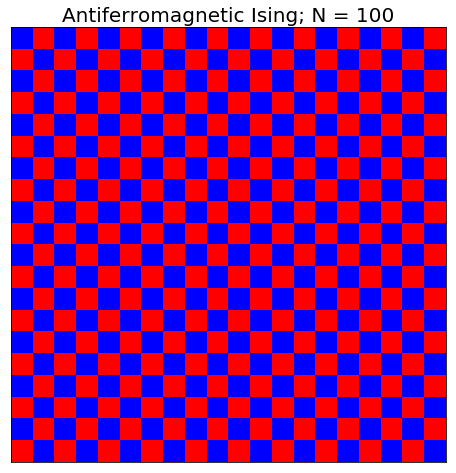

In [105]:
s = mult_sweeps_af(init, test_boltz, 100, plot = True, title = 'Antiferromagnetic Ising; N = 100')

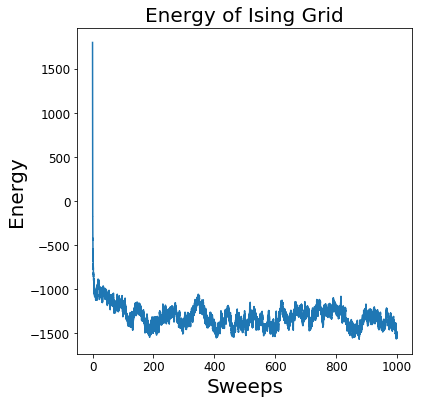

In [11]:
ones30 = np.ones((30,30))
T = 2.25
test_boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}

elist = energy_evo_af(ones30, test_boltz, 900*1000, plot = True)

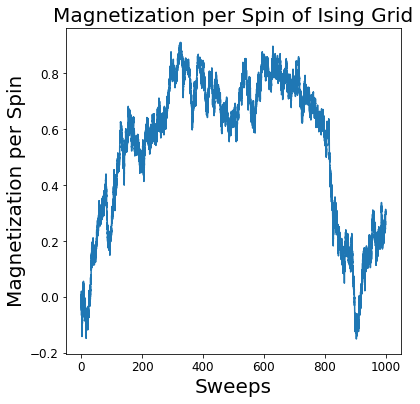

In [13]:
smlist = stag_mag_evo(ones30, test_boltz, 900*1000, plot = True)

In [14]:
def round_to_3(x):
    if x != 0:
        return round(x, -int(np.floor(np.log10(abs(x)))) + 2)
    else:
        return 0

In [44]:
# initialize to T = infinity
inftemp = np.random.randint(0, 2, (32, 32))

for i in range(32):
    for j in range(32):
        if inftemp[i,j] == 0:
            inftemp[i,j] = -1

            
temps = [i for i in np.arange(1.6, 3.01, 0.01)]
for i in range(len(temps)):
    temps[i] = round_to_3(temps[i])
    
t_points = len(temps)


# initialize dictionaries to store values
energy_dict = {}
smag_dict = {}

# set up keys and entries for dictionary
for T in temps:
    energy_dict[str(T)] = []
    smag_dict[str(T)] = []

# initialize lists to plot
eneps_list = np.zeros(t_points)
smagps_list = np.zeros(t_points)
spec_heat = np.zeros(t_points)
smag_sus = np.zeros(t_points)

# rough estimate for equilibration time
n_eq = 2000


# number of sweeps to average over
n = 500

# factors for averaging
n1 = 1/(n * 32**2)
n2 = 1/(n**2 * 32**2)

In [45]:
print(datetime.datetime.now().time())
start = time.time()


grid = copy.copy(inftemp)

for i in range(t_points):
    T = temps[i]
    boltz = {"4" : np.exp(-8/T), "2" : np.exp(-4/T)}
    
    for j in range(n_eq):
        grid = mc_sweep_af(grid, boltz)           # starts from the final config of the last temperature
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    smag_total = 0
    smag2_total= 0
    
    # dummy lists to hold the measurements
    e_all = np.zeros(n)
    sm_all = np.zeros(n)
    
    # measurements to average
    for k in range(n):
        grid = mc_sweep_af(grid, boltz)            
        energy = ising_energy_af(grid)
        smag = stag_mag(grid)
        
        e_total += energy
        e2_total += energy*energy
        smag_total += abs(smag)
        smag2_total += smag*smag
        
        e_all[k] = energy
        sm_all[k] = smag
        
    # storing all measurements for error purposes    
    energy_dict[str(T)] = e_all
    smag_dict[str(T)] = sm_all
    
    # compute averages
    eneps_list[i] = n1*e_total
    smagps_list[i] = n1*smag_total
    spec_heat[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    smag_sus[i] = (n1*smag2_total - n2*smag_total*smag_total)/T
    
    if (1.599 < T < 1.601) or (1.899 < T < 1.901) or (2.199 < T < 2.201) or (2.499 < T < 2.501) or (2.799 < T < 2.801):
        tick = time.time()
        print(f'T = {T}; {tick - start} seconds')
        
        
end = time.time()
print(f'Total time: {end - start}')   

11:34:40.790171
T = 1.6; 10.864380121231079 seconds
T = 1.9; 402.8262531757355 seconds
T = 2.2; 802.6660907268524 seconds
T = 2.5; 1124.079925775528 seconds
T = 2.8; 1454.1663162708282 seconds
Total time: 1669.7134535312653


Text(0,0.5,'Susceptibility')

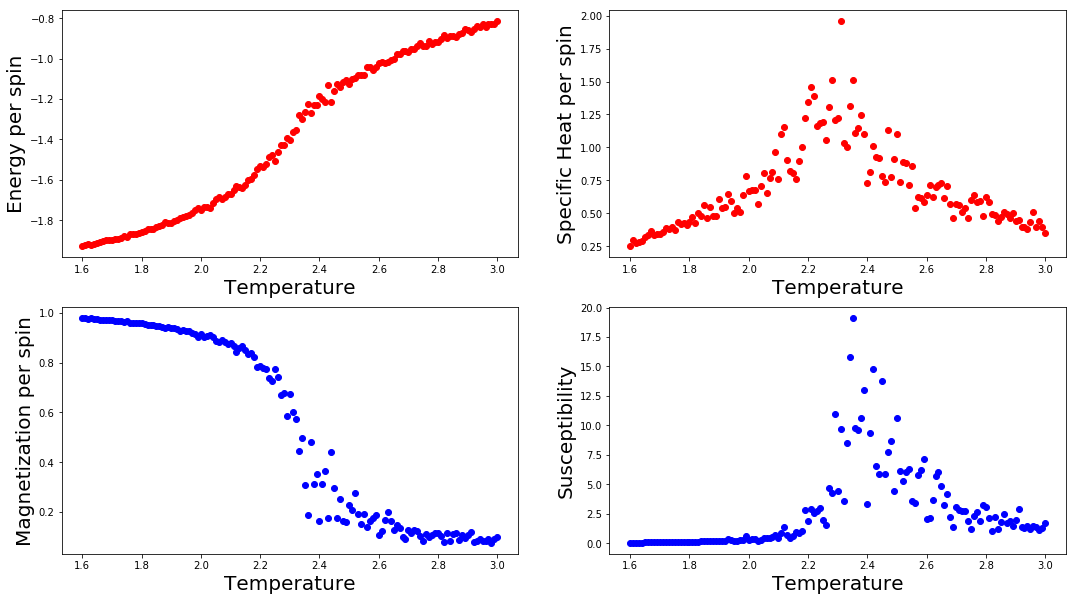

In [46]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, abs(smagps_list), 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, smag_sus, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)

In [47]:
np.save('AFeneps_list32v2.npy',eneps_list)
np.save('AFspec_heat32v2.npy',spec_heat)
np.save('AFsmagps32v2.npy',smagps_list)
np.save('AFsmag_sus32v2.npy',smag_sus)
np.save('AFene_dict32v2', energy_dict)
np.save('AFmag_dict32v2', smag_dict)